Epoch 1/150
413/413 [==============================] - 2s 4ms/step - loss: 0.6380 - val_loss: 0.4339
Epoch 2/150
413/413 [==============================] - 2s 4ms/step - loss: 0.4213 - val_loss: 0.3674
Epoch 3/150
413/413 [==============================] - 2s 4ms/step - loss: 0.3621 - val_loss: 0.2769
Epoch 4/150
413/413 [==============================] - 1s 3ms/step - loss: 0.3393 - val_loss: 0.3668
Epoch 5/150
413/413 [==============================] - 1s 3ms/step - loss: 0.3142 - val_loss: 0.3135
Epoch 6/150
413/413 [==============================] - 1s 3ms/step - loss: 0.3042 - val_loss: 0.2543
Epoch 7/150
413/413 [==============================] - 1s 3ms/step - loss: 0.2880 - val_loss: 0.2383
Epoch 8/150
413/413 [==============================] - 1s 3ms/step - loss: 0.2790 - val_loss: 0.2606
Epoch 9/150
413/413 [==============================] - 1s 3ms/step - loss: 0.2725 - val_loss: 0.2390
Epoch 10/150
413/413 [==============================] - 1s 3ms/step - loss: 0.2667 - val_lo

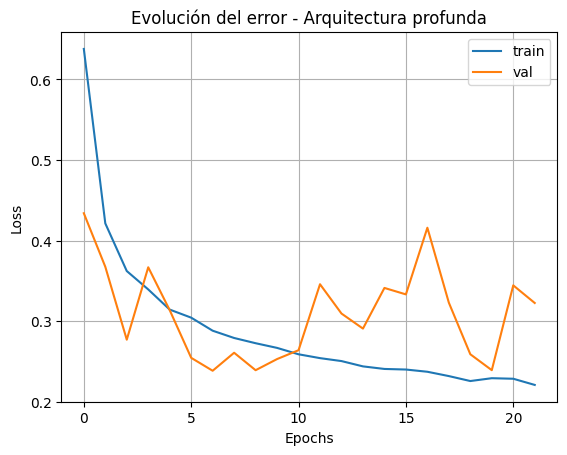

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from preprocessing import get_preprocessor
from tensorflow import keras
import matplotlib.pyplot as plt

# Cargar datos
housing = pd.read_csv("housing.csv")

# Separar X e y
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"].copy()

# División
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Escalar la variable objetivo
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Preprocesamiento
preprocessor = get_preprocessor(housing)
X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)

# Red neuronal profunda
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_train_prep.shape[1]),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="mean_squared_error", optimizer=optimizer)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

# Entrenamiento
history = model.fit(X_train_prep, y_train_scaled, epochs=150,
                    validation_data=(X_valid_prep, y_valid_scaled),
                    callbacks=[early_stopping_cb])

# Evaluación
y_valid_pred_scaled = model.predict(X_valid_prep)
y_valid_pred = y_scaler.inverse_transform(y_valid_pred_scaled)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("✅ RMSE validación (desescalado):", rmse_valid)

# Test
y_test_pred_scaled = model.predict(X_test_prep)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("✅ RMSE test (desescalado):", rmse_test)

# Guardar predicciones
pd.DataFrame({
    "y_real": y_test,
    "y_pred": y_test_pred.flatten()
}).to_csv("predicciones_test.csv", index=False)

# Visualización
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Evolución del error - Arquitectura profunda")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
